This notebook explores the typing data, to see what it is all about, and calculates basic statistics to see what we are dealing with. **I am writing a bash-script to do this because well, it is more fun, but more importantly; faster**.

---

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))


from haberrspd.preprocess import backspace_corrector, create_char_compression_time_mjff_data, sentence_level_pause_correction

import pandas as pd
import numpy as np
print(np.__version__)
from collections import Counter, defaultdict
from itertools import groupby
from operator import itemgetter
from scipy.stats import (gamma, lognorm, gengamma)

from pathlib import Path
from IPython.display import display

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Depending on where I am, set the path
import socket
if socket.gethostname() == 'pax':
    # Monster machine
    data_root = '../data/MJFF/' # My local path
    data_root = Path(data_root)
else:
    # Laptop
    data_root = '/home/nd/data/liverpool/MJFF' # My local path
    data_root = Path(data_root)

1.16.4


----

In [65]:
# Meta
df_meta = pd.read_csv(data_root / "EnglishParticipantKey.csv",  
                      header=0, 
                      names=['participant_id', 'ID', 'attempt', 'diagnosis'], 
                      usecols=['participant_id', 'diagnosis'])
# Actual
df = pd.read_csv(data_root / "EnglishData.csv")

In [ ]:
out, reference = create_NLP_datasets_from_MJFF_English_data()

In [66]:
df.head()

,timestamp,key,response_id,response_created,participant_id,sentence_id,sentence_text,parameters_workerId,parameters_consent
0,1439193925311,H,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
1,1439193925823,o,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
2,1439193926081,w,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
3,1439193926367,e,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
4,1439193926704,v,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip


In [3]:
key = list('pesto')
timestamp = [4,7,8,9,13]
participant_id = ['1a'] * len(key)
sentence_id = [1] * len(key)

df_test_small = pd.DataFrame(
    {'timestamp': timestamp,
     'key': key,
     'participant_id': participant_id,
     'sentence_id': sentence_id
    }
)

In [7]:
df.head()

,timestamp,key,response_id,response_created,participant_id,sentence_id,sentence_text,parameters_workerId,parameters_consent
0,1439193925311,H,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
1,1439193925823,o,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
2,1439193926081,w,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
3,1439193926367,e,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip
4,1439193926704,v,1010,2015-08-10T08:05:48.674Z,1a,55,"However, religions other than Islam, use a dif...",2,skip


In [52]:
df = pd.DataFrame(
    {'timestamp': [1,2,700,2,5,8,2,4,9,3,5,800],
     'key': list('car') + list('toy') + list('car') + list('toy'),
     'participant_id': ['1a'] * 6 + ['2a'] * 6,
     'sentence_id': [1] * 3 + [2] * 3 + [1] * 3 + [2] * 3
    }
)

In [56]:
from scipy.stats import gengamma

In [59]:
# Response time modelling
pause_funcs = {'gengamma': gengamma.fit, 'lognorm': lognorm.fit, 'gamma': gamma.fit}
pause_funcs_cut_off_quantile = {'gengamma': gengamma.ppf, 'lognorm': lognorm.ppf, 'gamma': gamma.ppf}
pause_first_moment = {'gengamma': gengamma.mean, 'lognorm': lognorm.mean, 'gamma': gamma.mean}

In [81]:
A = df.loc[df.participant_id == '10a'].timestamp.diff().values[1:3]

In [82]:
A

array([183., 277.])

In [88]:
gengamma.fit([2,700])

(0.5490248014825481,
 -0.07141786886896503,
 1.9999999999999996,
 1.4362755211649652)

In [89]:
params_MLE

(0.5490248014825481,
 -0.07141786886896503,
 1.9999999999999996,
 1.4362755211649652)

In [87]:
# Fit suitable density for modelling correct replacement value
correction_model = 'gengamma'
cut_off_percentile = 0.99
params_MLE = pause_funcs[correction_model]([2,700])
# cut_off_value = pause_funcs_cut_off_quantile[correction_model](*((cut_off_percentile,) + params_MLE))
# assert cut_off_value > 0, cut_off_value
# replacement_value = pause_first_moment[correction_model](*params_MLE)
# assert replacement_value > 0, replacement_value

/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2714: RuntimeWarning: divide by zero encountered in power
  return np.log(abs(c)) + sc.xlogy(c*a - 1, x) - x**c - sc.gammaln(a)
/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2714: RuntimeWarning: invalid value encountered in subtract
  return np.log(abs(c)) + sc.xlogy(c*a - 1, x) - x**c - sc.gammaln(a)


In [64]:
replacement_value

2.0000000001381015

In [53]:
df

,timestamp,key,participant_id,sentence_id
0,1,c,1a,1
1,2,a,1a,1
2,700,r,1a,1
3,2,t,1a,2
4,5,o,1a,2
5,8,y,1a,2
6,2,c,2a,1
7,4,a,2a,1
8,9,r,2a,1
9,3,t,2a,2


In [ ]:
df.loc

### Expected output

In [44]:
out[1]['1a'] = [np.nan, 1.,3.]
out[2]['1a'] = [np.nan, 3.,3.]
out[1]['2a'] = [np.nan, 2.,5.]
out[2]['2a'] = [np.nan, 2.,3.]

0    NaN
1    3.0
2    3.0
dtype: float64

In [54]:
out = sentence_level_pause_correction(df,char_count_response_threshold=2)

In [55]:
out

defaultdict(dict, {1: {'1a': 0          NaN
              1     1.000000
              2    81.754372
              dtype: float64, '2a': 0    NaN
              1    2.0
              2    5.0
              dtype: float64}, 2: {'1a': 0    NaN
              1    3.0
              2    3.0
              dtype: float64, '2a': 0          NaN
              1     2.000000
              2    65.591521
              dtype: float64}})

## PLOT

In [15]:
controls = set(df_meta.loc[df_meta.diagnosis == 0].participant_id)
pd_subjects = set(df_meta.loc[df_meta.diagnosis == 1].participant_id)

In [16]:
pd_timestamp_diffs = []
# Loop over all subjects
for sub in pd_subjects:
    # Get all delta timestamps for this sentence, across all subjects
    pd_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)
    
control_timestamp_diffs = []
# Loop over all subjects
for sub in controls:
    # Get all delta timestamps for this sentence, across all subjects
    control_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)

In [17]:
# remove NaNs
pd_cleaned_list = [x for x in pd_timestamp_diffs if str(x) != 'nan']
control_cleaned_list = [x for x in control_timestamp_diffs if str(x) != 'nan']

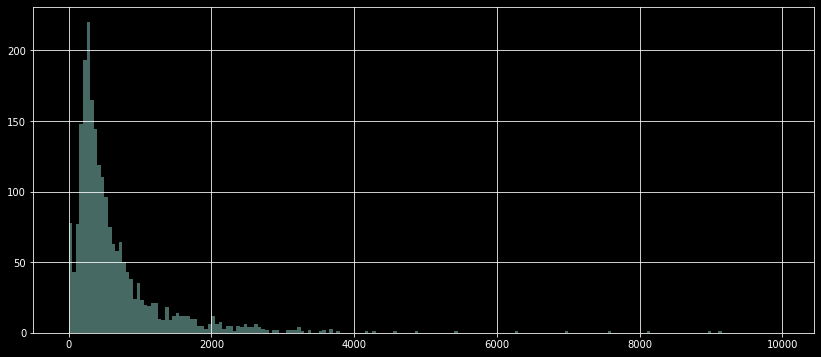

In [19]:
# PD

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(pd_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

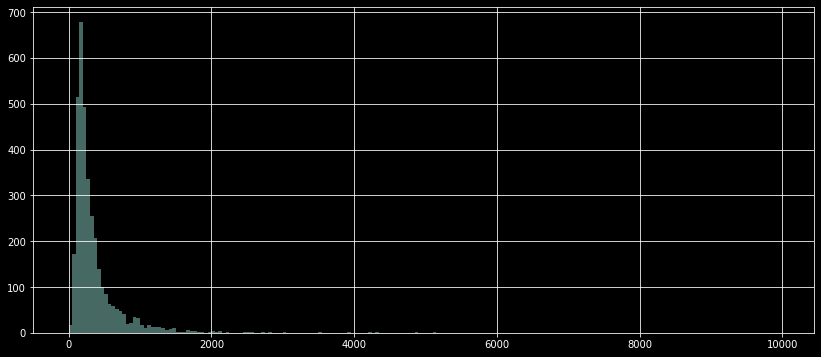

In [20]:
# control

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(control_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

### Save the English data to use in downstream tasks

In [7]:
out.to_csv(data_root /'preprocessed_EnglishData.csv',index=False)
reference.to_csv(data_root /'EnglishData_target_sentences.csv',index=False)

### Mechanical turk data

In [15]:
out.to_csv(data_root /'preprocessed_MechanicalTurkCombinedEnglishData.csv',index=False)

In [14]:
ls ../data/MJFF/

EnglishData.csv
EnglishParticipantKey.csv
fasttext/
MechanicalTurkCombinedEnglishData.csv
MechanicalTurkEnglishParticipantKey.csv
MTurk1.csv
MTurk2.csv
preprocessed_EnglishData.csv
preprocessed_MechanicalTurkCombinedEnglishData.csv
README
SpanishData.csv
SpanishParticipantKey.csv
test_MJFF_English.csv
train_MJFF_English.csv
validate_MJFF_English.csv


### IKI extraction

In [4]:
out = create_mjff_iki_training_data(df)

In [6]:
out['10a'][0]

array([    0,   141,   235,   323,   414,   525,   723,   940,  1081,
        1161,  1215,  1290,  1573,  1687,  1778,  1885,  2000,  2465,
        2689,  2769,  2926,  3044,  3122,  3189,  3508,  3703,  3796,
        3942,  4053,  4196,  4464,  4663,  4777,  4875,  4973,  5081,
        5230,  5341,  5453,  5480,  5597,  5758,  6091,  6332,  6342,
        6813,  6934,  7104,  7242,  7381,  7471,  7518,  7690,  7774,
        7914,  8089,  8250,  8377,  8531,  9315,  9357,  9879,  9965,
       10131, 10258, 10366, 10445, 10589, 10680, 10754, 10826, 10952,
       11016, 11124, 11204, 11385, 11545, 11753, 11891, 12135, 12496,
       12839, 13018, 13115, 13184, 13351, 13719, 13935, 14118, 14641,
       14724, 15892, 16062, 16332, 16462, 16584, 16906, 16981, 17413,
       17541, 17696, 17758, 17834, 17986, 18108, 18122, 18193, 18348,
       18529, 18923, 19083, 19224, 19555, 19749, 20011, 20052, 20179,
       20259, 20714, 20847, 21805, 21920, 22047, 22534, 22981, 23118,
       24108, 24205,

## Add Spanish data

In [2]:
test = create_NLP_datasets_from_MJFF_Spanish_data()

/home/neil/cloud/haberrspd/notebooks/../haberrspd/preprocess.py:263: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  invoked_sentence = np.delete(sentence, remove_cords).tolist()


In [5]:
test.to_csv(data_root /'preprocessed_SpanishData.csv',index=False)

## Long format data

In [3]:
from haberrspd.preprocess import create_char_compression_time_mjff_data, create_long_form_NLP_datasets_from_MJFF_English_data

In [97]:
df.loc[df.participant_id.isin(['10a','1a'])].shape

(3912, 9)

In [5]:
out = create_char_compression_time_mjff_data(df)

/home/neil/cloud/haberrspd/notebooks/../haberrspd/preprocess.py:367: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  invoked_sentence = np.delete(sentence, remove_cords).tolist()


In [12]:
out['10a'][55]

'HHHHHHHHHHHHHHHHHHooooooooooooooooooooooooooowwwwwwwwwwwwwwwwwwwwwweeeeeeeeeeeeeevvvvvvvvveeeeeeeeerrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr,,,,,,               rrrrreeeeeeeeelllllllllaaaaaaaaaaaattttttiiiiiiioooooooooooooooonnnnnnnnnnnnssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssiiiiiiiiiiiiiiiiiiiiiigggggggggggggiiiiiiooooooooooooooooonnnnnnnnnnsssssssssssssssssssssssssssssssssssssssssssssss

In [11]:
for sub in out.keys():
    tmp = []
    for sent in out[sub].keys():
        tmp.append(len(out[sub][sent]))
    print('The sequence lengths for subject {0} is: {1}.'.format(sub, tmp))

The sequence lengths for subject 10a is: [2537, 1412, 1076, 1819, 1447, 2327, 2263, 2249, 2528, 1314, 1834, 2015, 2354, 1576, 1620].
The sequence lengths for subject 10b is: [1748, 1030, 952, 1900, 1508, 2370, 2477, 1819, 2222, 1247, 1840, 1876, 2275, 1533, 2157].
The sequence lengths for subject 11a is: [2504, 1449, 1371, 2649, 2003, 2846, 2462, 2518, 3481, 1751, 2193, 2638, 2600, 2537, 2417].
The sequence lengths for subject 11b is: [2600, 1423, 1398, 2446, 2093, 2565, 2445, 2661, 2575, 1808, 2316, 2282, 3095, 2245, 2318].
The sequence lengths for subject 12a is: [5067, 3169, 2402, 4586, 3745, 5651, 4785, 5172, 6072, 3796, 5818, 5628, 6626, 4866, 4565].
The sequence lengths for subject 12b is: [4373, 2957, 2399, 4042, 3756, 6441, 5051, 5236, 6505, 4214, 5212, 7894, 6697, 4746, 4727].
The sequence lengths for subject 13a is: [4531, 2380, 2159, 3692, 3566, 5391, 3758, 3769, 5110, 2572, 3881, 4713, 4492, 3373, 4031].
The sequence lengths for subject 13b is: [5138, 2070, 1892, 3536, 3217

In [9]:
a,b = create_long_form_NLP_datasets_from_MJFF_English_data()

In [13]:
a.head()

,Patient_ID,Diagnosis,Sentence_ID,Preprocessed_typed_sentence
0,10a,0,55,HHHHHHHHHHHHHHHHHHooooooooooooooooooooooooooow...
1,10a,0,56,HHHHHHHHHHeeeee iiiiiiiiisssssss ...
2,10a,0,57,BBBBBBBBBBBBBBBBBBBBBBBBBBoooooooooooooooooooo...
3,10a,0,58,TTTTTTTTTTTTTThhhhhhhheeeeeeeeeeeeeeeeeeeeeeee...
4,10a,0,59,TTTTTTTTTTTTTThhhhhhheeeeeeee ...


In [10]:
a.Preprocessed_typed_sentence[0]

,Patient_ID,Diagnosis,Sentence_ID,Preprocessed_typed_sentence
0,10a,0,55,HHHHHHHHHHHHHHHHHHooooooooooooooooooooooooooow...
1,10a,0,56,HHHHHHHHHHeeeee iiiiiiiiisssssss ...
2,10a,0,57,BBBBBBBBBBBBBBBBBBBBBBBBBBoooooooooooooooooooo...
3,10a,0,58,TTTTTTTTTTTTTThhhhhhhheeeeeeeeeeeeeeeeeeeeeeee...
4,10a,0,59,TTTTTTTTTTTTTThhhhhhheeeeeeee ...
